## GROUP 4
- Lorenza Cotugno
- Lorenza Di Mauro
- Raffaele Sannino
- Maria Raffaella Zampella

# IMPORTING LIBRARIES

### Importing libraries about the preprocessing work on images and the dataset

We uploaded on our drive account the datasets, but in any case it is possible to use which dataset you prefer.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install scikit-image

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
from skimage.transform import resize
from skimage.io import imsave, imread

### Importing libraries in order to implement the network

In [ ]:
from keras.layers import Layer
from keras.layers import Conv2D, Conv3D, UpSampling2D, InputLayer, Conv2DTranspose, Input, Reshape, concatenate
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.callbacks import TensorBoard
from keras.models import Sequential, Model
from keras.datasets import cifar10

### Other useful libraries

In [ ]:
import numpy as np
import os, shutil, sys
import PIL
import random
import tensorflow as tf

# PREPROCESSING

Here we used the Landscape dataset available on https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization. We have to manage carefully the *batch_size* value because the RAM may not make it.
We decide to take 1500 images for the train set.


In [ ]:
datagen = ImageDataGenerator(rescale = 1./255)
train = datagen.flow_from_directory("/content/drive/MyDrive/sunset/landscape_Images/train", target_size= (256, 256), batch_size= 1500, class_mode = None) 

Found 2050 images belonging to 1 classes.


In [ ]:
len(train[0])   #20x256x256x3

1500

### RGB to Lab representation

We transform each image into LAB space.
- **X** collects the **L** channel, hence the **lightness** of the image. Each element of this list is a float between 0 to 100;
- **Y** collects the **ab** channels, hence the colours of the image. Each element of this list is a float between -128 to 127, so we divided the A and B values by 128. In such a way we obtain a number between -1 and 1 that will be the output of our model.

In [ ]:
X =[]
Y =[]
for img in train[0]:
  try:
      lab = rgb2lab(img)
      X.append(lab[:,:,0])
      Y.append(lab[:,:,1:] / 128)
  except:
     print('error')
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,))
print(X.shape)
print(Y.shape)


(1500, 256, 256, 1)
(1500, 256, 256, 2)


# BUILDING THE AUTOENCODER

The next step is building the Autoencoder model which is composed by two parts: the Encoder and the Decoder. \\
Notice that the last activation function is tanh because we want an output in the inverval [-1,1].

In [ ]:
#Encoder
encoder_input = Input(shape=(256, 256, 1,))
encoder_output = Conv2D(64, (3,3), activation='relu', padding='same', strides=2)(encoder_input)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(128, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same', strides=2)(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(512, (3,3), activation='relu', padding='same')(encoder_output)
encoder_output = Conv2D(256, (3,3), activation='relu', padding='same')(encoder_output)
#Decoder
decoder_output = Conv2D(128, (3,3), activation='relu', padding='same')(encoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(64, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
decoder_output = Conv2D(32, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(16, (3,3), activation='relu', padding='same')(decoder_output)
decoder_output = Conv2D(2, (3, 3), activation='tanh', padding='same')(decoder_output)
decoder_output = UpSampling2D((2, 2))(decoder_output)
model = Model(inputs=encoder_input, outputs=decoder_output)

After building the model we can train it.
We train the model for 100 epochs.

In [ ]:
model.compile(optimizer= 'adam', loss='mse' , metrics=['accuracy'])
model.fit(X,Y,validation_split=0.2, epochs=100, batch_size = 64)

Epoch 1/100
19/19 [==============================] - 46s 1s/step - loss: 0.2220 - accuracy: 0.5065 - val_loss: 0.0122 - val_accuracy: 0.4793
Epoch 2/100
19/19 [==============================] - 13s 667ms/step - loss: 0.0121 - accuracy: 0.4951 - val_loss: 0.0121 - val_accuracy: 0.5153
Epoch 3/100
19/19 [==============================] - 13s 671ms/step - loss: 0.0120 - accuracy: 0.5151 - val_loss: 0.0118 - val_accuracy: 0.5783
Epoch 4/100
19/19 [==============================] - 13s 670ms/step - loss: 0.0119 - accuracy: 0.5375 - val_loss: 0.0118 - val_accuracy: 0.5841
Epoch 5/100
19/19 [==============================] - 13s 674ms/step - loss: 0.0118 - accuracy: 0.5625 - val_loss: 0.0118 - val_accuracy: 0.5253
Epoch 6/100
19/19 [==============================] - 13s 678ms/step - loss: 0.0118 - accuracy: 0.5620 - val_loss: 0.0121 - val_accuracy: 0.5084
Epoch 7/100
19/19 [==============================] - 13s 681ms/step - loss: 0.0118 - accuracy: 0.5583 - val_loss: 0.0115 - val_accuracy: 0.

We can save the model to use it later.

In [ ]:
model.save("/content/drive/MyDrive/color_autoencoder.model")

# TESTING THE MODEL

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/color_autoencoder.model',custom_objects=None,compile=True)

We select randomly 10 image from the test data set for testing our trained model. \\
The 10 selected images must be rescaled and reshaped in order to satisfy the dimensions of the model input.

In [ ]:
img1_color=[]  
for i in  np.random.choice(np.arange(start = 0, stop = 150), size=10, replace=False):
  img1 = img_to_array(load_img("/content/drive/MyDrive/sunset/landscape_Images/test/{num}.jpg".format(num = i)))   
  img1 = resize(img1, (256, 256))   
  img1_color.append(img1)  
  
img1_color_daje = np.array(img1_color, dtype=float) 
img1_color_daje = rgb2lab(1.0/255 * img1_color_daje)[:,:,:,0] 
img1_color_daje = img1_color_daje.reshape(img1_color_daje.shape+(1,))

As previously noticed, the output is in the interval [-1,1]. So, to plot the  colorized image obtained by the model we need to multiply it by 128 (A and B channels assume values into [-127,218]) 

In [ ]:
output1 = model.predict(img1_color_daje)
output1 = output1*128

1/1 [==============================] - 1s 994ms/step


In [ ]:
results = []
for i in range(len(output1)):
    
    result = np.zeros((256, 256, 3))
    result[:,:,0] = img1_color_daje[i][:,:,0]
    result[:,:,1:] = output1[i]
    
    results.append(result)

Eventually, we plot the original image and the predicted one for the 10 samples of the test data set.

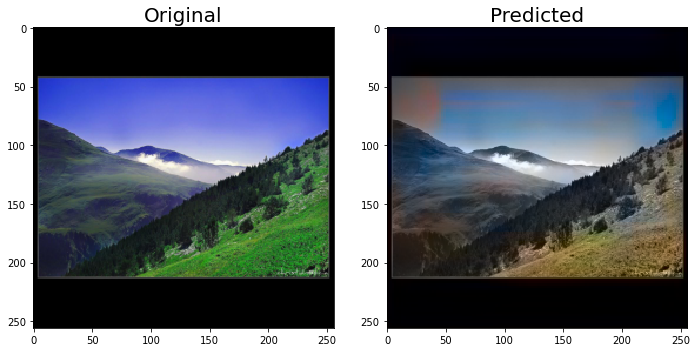

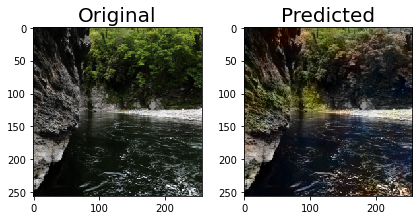

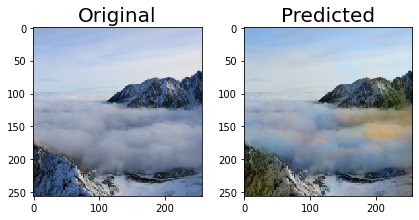

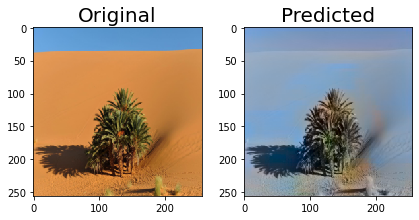

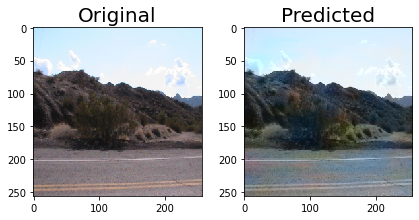

In [ ]:
import matplotlib.pyplot as plt
from skimage.io import imshow

plt.figure(figsize=(10,5))
for i in range(5):
  
  plt.subplot(121)
  plt.title('Original', fontsize=20)
  imshow(img1_color[i]/255.0)

  plt.subplot(122)
  plt.title('Predicted', fontsize=20)
  imshow(lab2rgb(results[i]))

  plt.show()